In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Splitting the dataset

In this section, the given dataset will be split into a train and a test set with a proportion of 80:20. All the data analysis and training process, including data pre-processing, baseline model training, and hyperparameter tuning, will be performed on the training set. The test set is used for the final evaluation. Moreover, as working with medical data, the dataset will be divided based on the **patient** level to: 
- Prevent the data leakage, when the instance appears in both the train and test sets, resulting in the model learn on the data it is trained on
- Mimic the scenario of diagnosing the new patient via a generalizing model
- Avoid patient correlations that result in a skewed evaluation.



In [2]:
# Load the data set
dataset_path = './data/data_labels_mainData.csv'
data = pd.read_csv(dataset_path)

In [3]:
print(f"The shape of the dataset is: {data.shape}")

The shape of the dataset is: (9896, 6)


The dataset has **9896** records.

In [4]:
def plot_categorical_distribution(data):
    # Prepare data
    cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
    cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot 1: Cancerous vs Non-Cancerous
    sns.countplot(x='isCancerous', data=data, ax=axes[0])
    axes[0].set_title('Cancerous vs Non-Cancerous')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'])
    
    # Plot 2: Cell Type Distribution
    sns.barplot(data=cell_type_counts, x="cellTypeName", y="Count", ax=axes[1])
    axes[1].set_title('Cell Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

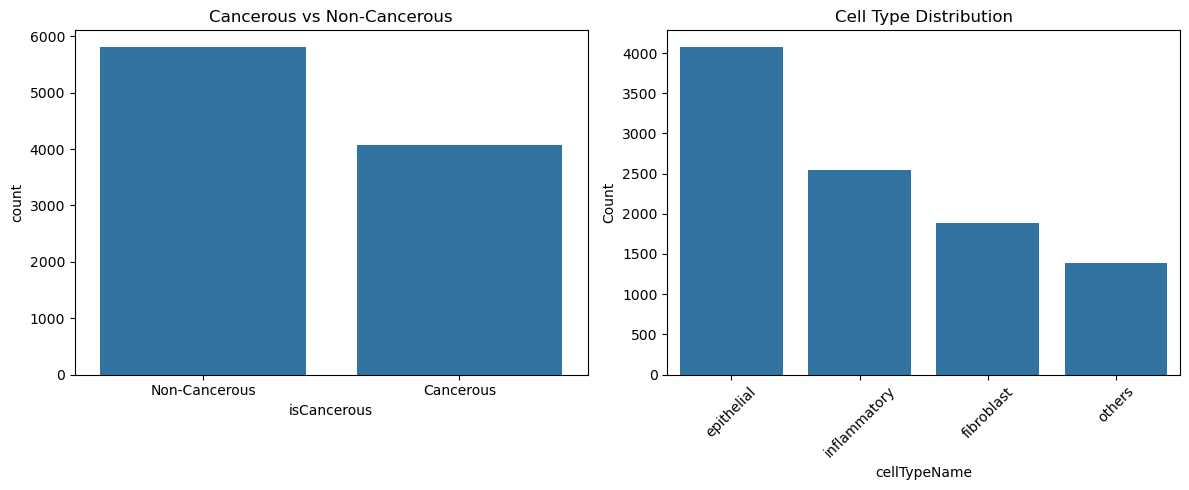

In [5]:
plot_categorical_distribution(data)

The generated graphs depict the the distribution of the two categorical variables: **isCanerous** and **cellType**. From the graph, the distribution is not distributed evenly. Therefore, when splitting the data to train and test sets, both sets should have the classes to train or test. Also, the miniroty should have enough data to train (**>20 samples**). **TODO: ADD REFERENCE HERE**

In [6]:
from sklearn.model_selection import train_test_split

# Create a combined label per patient for stratification (if patients have varying labels)
patient_data = data.groupby('patientID').agg({
    'cellType': lambda x: x.mode()[0],  # Or a more robust method if needed
    'isCancerous': lambda x: x.mode()[0]
}).reset_index()

# Create stratification target per patient
patient_data['combined_target'] = patient_data['cellType'].astype(str) + '_' + patient_data['isCancerous'].astype(str)

# Split patient IDs
train_patients, test_patients = train_test_split(
    patient_data['patientID'],
    test_size=0.20,
    random_state=0,
    stratify=patient_data['combined_target']
)

# Filter the main data by patient ID
train_data = data[data['patientID'].isin(train_patients)]
test_data = data[data['patientID'].isin(test_patients)]

# Define targets
y_train = train_data['cellType'].astype(str) + '_' + train_data['isCancerous'].astype(str)
y_test = test_data['cellType'].astype(str) + '_' + test_data['isCancerous'].astype(str)


In [7]:
train_data.shape

(7768, 6)

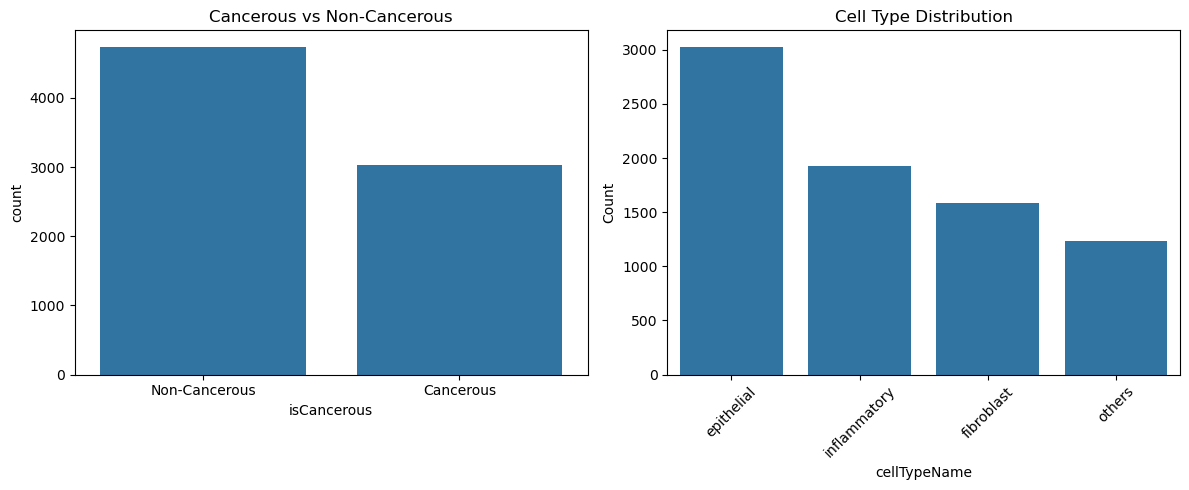

In [8]:
plot_categorical_distribution(train_data)

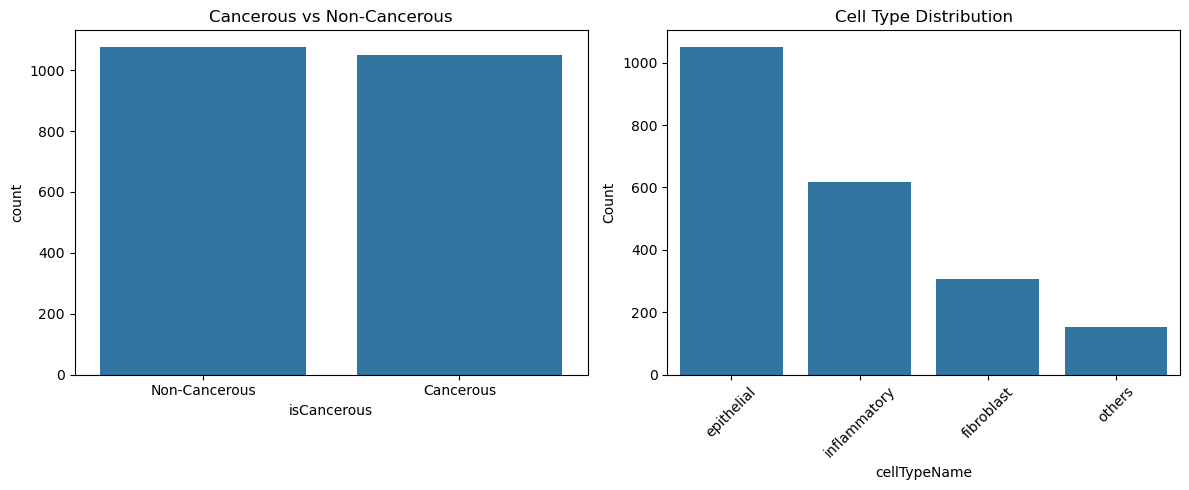

In [9]:
plot_categorical_distribution(test_data)

From the generated figures, both train and test set contains enough data to train and test.

In [10]:
# This code is used to do the final check to ensure that there is no instances that appear in both train and set set
patient_train_data = train_data['patientID'].unique()
patient_test_data = test_data['patientID'].unique()

res = list(set(patient_train_data) & set(patient_test_data))
if len(res) == 0:
    print("In both train and test sets, there is no record with same ID")
else:
    print("WARN: The dataset has leakage issue")

In both train and test sets, there is no record with same ID


In [11]:
# export to csv
train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)